**1. Загружаем необходимые модули и данные**

In [28]:
%matplotlib inline

In [30]:
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2024-01-08 16:10:59--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.164.174.99, 18.164.174.79, 18.164.174.78, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.164.174.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.06s   

2024-01-08 16:11:00 (44.5 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/It

In [4]:
!tail data/eng-fra.txt

Five tremors in excess of magnitude 5.0 on the Richter scale have shaken Japan just this week, but scientists are warning that the largest expected aftershock has yet to hit.	Cinq secousses dépassant la magnitude cinq sur l'échelle de Richter ont secoué le Japon précisément cette semaine, mais les scientifiques avertissent que la plus grande réplique est encore à venir.
No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.	Peu importe le temps que tu passeras à essayer de convaincre les gens que le chocolat est de la vanille, ça restera toujours du chocolat, même si tu réussis à convaincre toi et quelques autres que c'est de la vanille.
A child who is a native speaker usually knows many things about his or her language that a non-native speaker who has been studying for years still does not know and perhaps will never know.	Un enfant qui est un locuteur natif

**2. Создаем словарь**

In [5]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {} # словарь перевода слова в индекс
        self.word2count = {} # словарь-счетчик встречаимости слов в тексте
        self.index2word = {0: "SOS", 1: "EOS"} # словарь перевода слова в индекс (SOS-начало, EOS-конец)
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence): # функция добавки слов из предложения
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word): # функция добавления слова в словари
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

**3. Предварительная обработка текста**

In [6]:
# Преобразуйте строку Unicode в обычный ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Строчные буквы, обрезка и удаление небуквенных символов


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

**4. Обработка словарей, компановка пар предложений в список списков**

In [7]:
# Функция читающая словари, на входе 2 словаря, reverse=False - задает направление перевода
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # читаем файл и разбиваем на строки по \n
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # делаем список списков с парами выражение-перевод и нормализуем
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # блок регламентирующий, что делать при прямом или реверсивном переводе
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs # словарь входной, словарь выхоной, список списков пар

**5. Ограничения**

In [8]:
MAX_LENGTH = 10 # ограничение числа слов в предложении, не более 10-ти будет

# все фразы гначинаются с нижеуказанных слов
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# проверяет пару предложений на соответствие
# 1. проверяет длину первого предложения
# 2. проверяет длину второго предложения
# 3. проверяет второе предложение, начинается ли оно с вышеуказанных символов
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and  \
        len(p[1].split(' ')) < MAX_LENGTH and  \
        p[1].startswith(eng_prefixes)

# функция фильтра пар по вышеуказанным параметрам
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

**6. Формирует наши данные**

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse) # словарь входной, словарь выхоной, список списков пар
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs) # фильтруем пары
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs: # заполняем словари словами, имеющимися в наших языках
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs # словарь входной, словарь выхоной, список списков пар (уже отфильтрованные)


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je ne m enfuis pas .', 'i m not running away .']


**7.The Encoder**
-----------




In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**8. The Decoder**
-----------




In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

#-------------------------------------------------------------------------------
# блок внимания
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
#-------------------------------------------------------------------------------

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

**9. Функции перевода индексов**

In [12]:
# берет предложение, разбивает по пробелам и переводит в индекс
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# берет предложение, переводит в индексы, добавляет токен EOS
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# переводим пары в тензоры
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

**10. Функция обучения на одном предложении**

!!! функция **train** учится на одном предложении

In [13]:
# если число из некого распределения будет < 0.5, то используем teacher_forcing,
# т.е. показываем модели правильный ответ (слово), если наоборот, то наоборот
teacher_forcing_ratio = 0.5

# входной тензор, выходной тензор, функция encoder, функция decoder, оптимайзеры, функция потерь, max_length - задана выше, max длина предложения
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden() # инициализируем скрытое представлене

    # сбрасываем градиенты
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # длины входных тензоров
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # матрица с выходами (вроде для внимания нужна)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0] # для внимания заполняется матрица, здесь не понадобица

    decoder_input = torch.tensor([[SOS_token]], device=device) # входной токен, ну чтобы начать предсказывать

    decoder_hidden = encoder_hidden # размеры скрытых представлений д.б. одинаковыми

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            # decoder_output - распределение вероятности предсказанного слова
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # decoder_output - распределение вероятности предсказанного слова
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1) # topv, topi - максимальное значение и индекс max значения
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length #  усредненный лосс по предложению

**11. Функции работы со временем**

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

**12. Функция обучения на всех данных**

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    # достаем случайную пару и переводим в тензор:
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses) # нарисует кривую обучения

**13. Функция для вывода результатов обучения**

In [16]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

**14. Функция, которая будет переводить текст, опираясь на обученную модель**

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

**15. Функция берет случайно 19 пар и делает перевод**

In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

**16. Само обучение**

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 37s (- 22m 42s) (5000 6%) 2.9155
3m 9s (- 20m 30s) (10000 13%) 2.3417
4m 40s (- 18m 41s) (15000 20%) 2.0342
6m 12s (- 17m 4s) (20000 26%) 1.7803
7m 43s (- 15m 26s) (25000 33%) 1.5834
9m 14s (- 13m 51s) (30000 40%) 1.4382
10m 45s (- 12m 18s) (35000 46%) 1.3016
12m 19s (- 10m 46s) (40000 53%) 1.1785
13m 51s (- 9m 14s) (45000 60%) 1.0629
15m 22s (- 7m 41s) (50000 66%) 0.9667
16m 54s (- 6m 8s) (55000 73%) 0.8486
18m 26s (- 4m 36s) (60000 80%) 0.7956
19m 59s (- 3m 4s) (65000 86%) 0.7307
21m 31s (- 1m 32s) (70000 93%) 0.6485
23m 4s (- 0m 0s) (75000 100%) 0.6210


**17. Предсказываем**

In [24]:
evaluateRandomly(encoder1, attn_decoder1)

> c est l homme parfait pour toi .
= he s the perfect man for you .
< he s the perfect man for you . <EOS>

> elle ne devrait pas y aller seule .
= she shouldn t go by herself .
< she isn t herself . <EOS>

> tu es un bon etudiant .
= you are a good student .
< you are a good student . <EOS>

> vous etes la plus grande personne ici .
= you re the tallest person here .
< you re the tallest person here . <EOS>

> je vais au lit .
= i am going to bed .
< i m going to bed . <EOS>

> je n ai pas fini .
= i m not done .
< i m not done . <EOS>

> vous avez tellement de talent !
= you re so talented .
< you re so talented . <EOS>

> tu viens tot .
= you re here early .
< you re early . <EOS>

> je travaille a mon nouveau livre .
= i am working on my new book .
< i am working on my new book . <EOS>

> il est occupe a apprendre l anglais .
= he is busy learning english .
< he is busy learning english . <EOS>



**18. Отражает матрицу весов для предложения**

<Figure size 640x480 with 0 Axes>

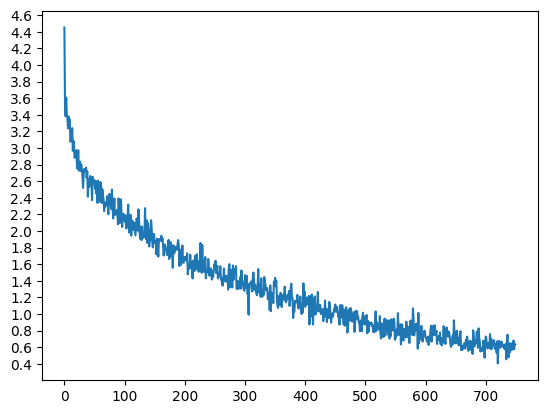

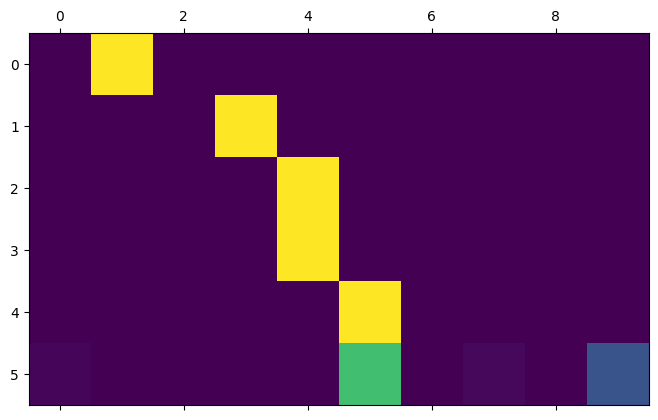

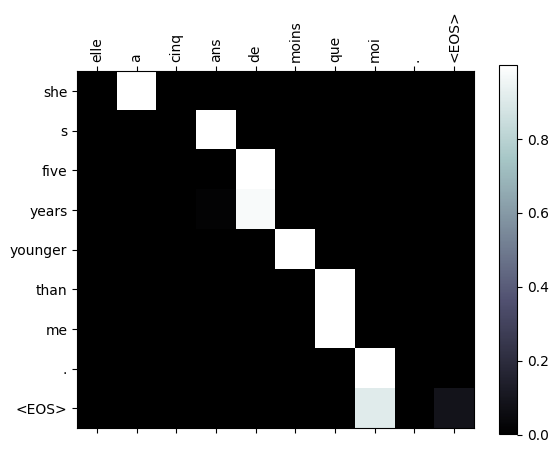

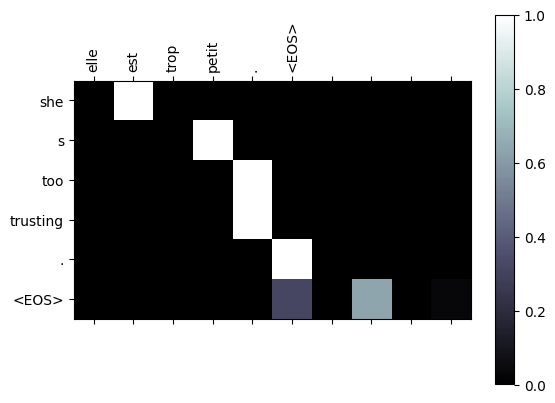

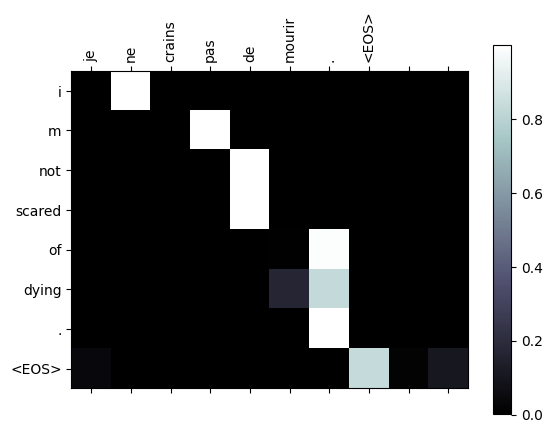

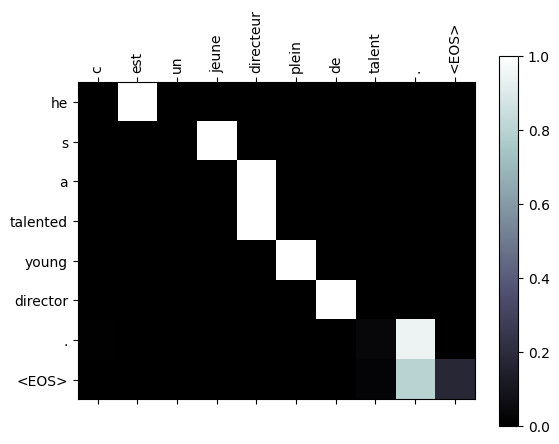

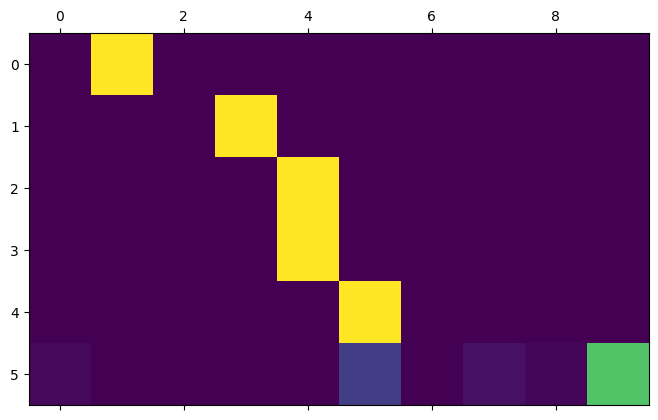

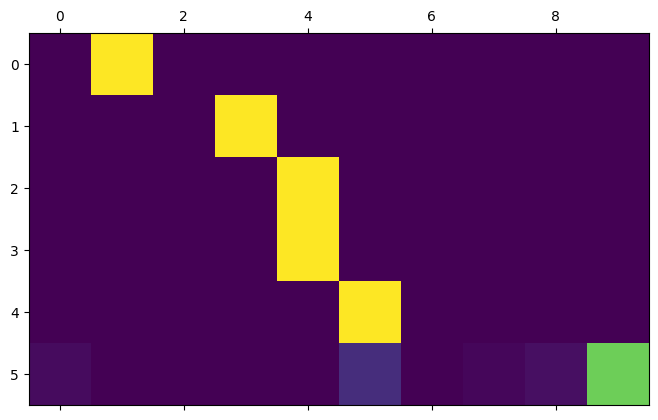

In [31]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())
plt.show()

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


<ipython-input-32-9b51ff8fc28e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-32-9b51ff8fc28e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


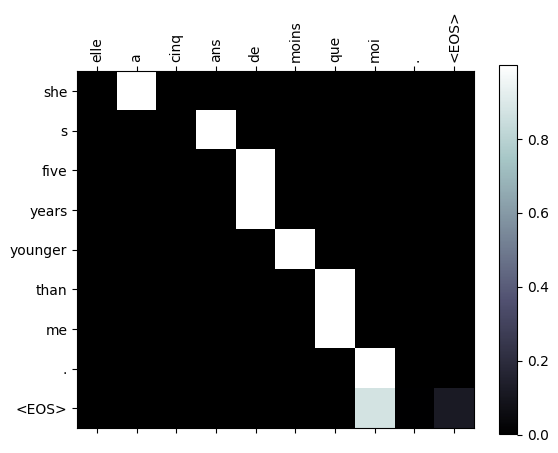

input = elle est trop petit .
output = she s too trusting . <EOS>


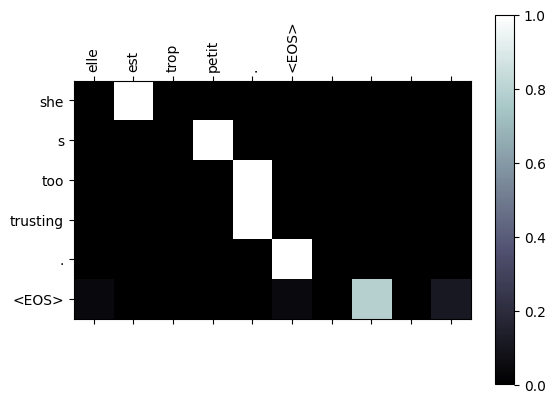

input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


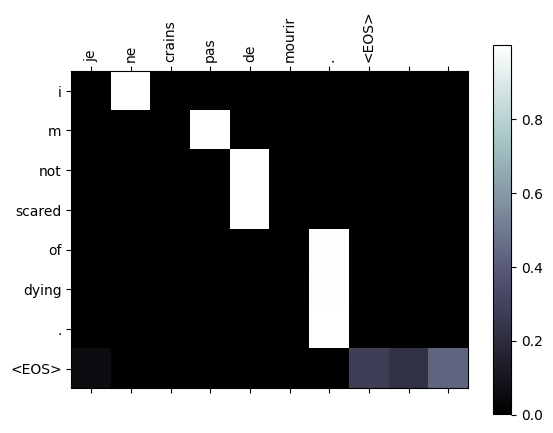

input = c est un jeune directeur plein de talent .
output = he s a talented young director . <EOS>


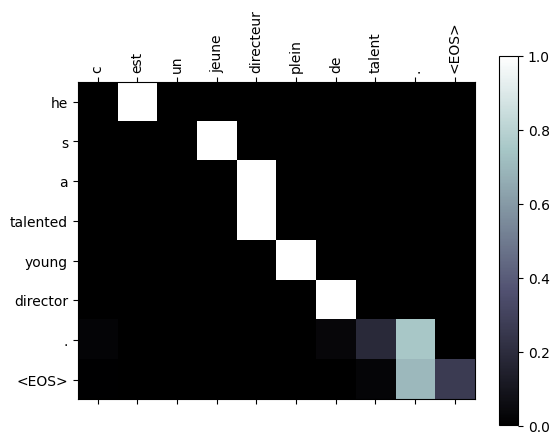

In [32]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")